<a href="https://colab.research.google.com/github/thenoorfatima/PyTorch/blob/main/Pytorch%20Multiclass%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class PyTorch model

## Creating multi-class classification data

Scikit-Learn's make_blobs() method: create any no. of classes using the centers parameter.

1. Create multi-class data with make_blobs().
2.Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
3. Split the data into training and test sets using train_test_split().
4. Visualize the data.

Build a model to separate the coloured blobs.


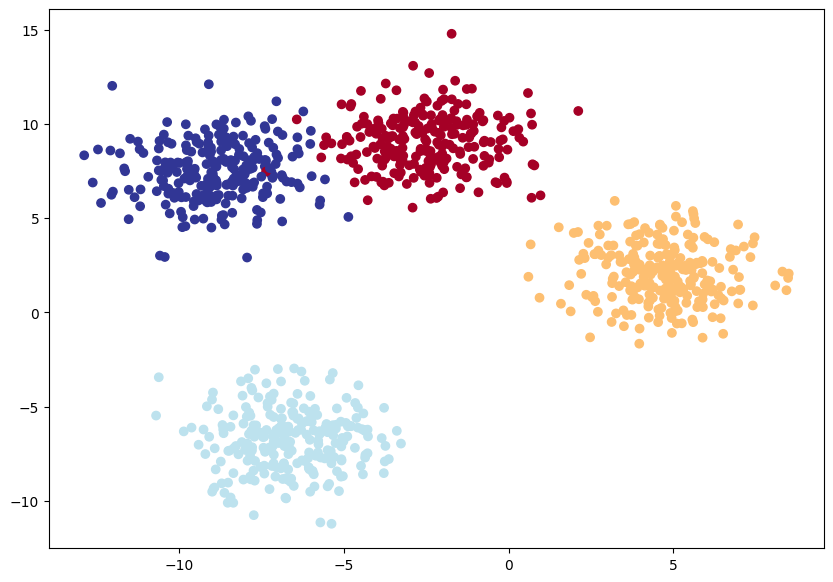

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES, # X features
                            centers = NUM_CLASSES,     # y labels
                            cluster_std = 1.5,  # give clusters a little shake up
                            random_state = RANDOM_SEED
                            )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## Building a multi-class classification model in PyTorch

Subclass of nn.Module that takes in 3 hyperparameters:

* input_features - number of X features coming into the model.
* output_features - ideal numbers of output features (NUM_CLASSES).
* hidden_units - number of hidden neurons each hidden layer use, default 8.

In [2]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

class Blob(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
     #Initializes all required hyperparameters for multi-class classification model.

     super().__init__()
     self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features),
        )

  def forward(self, x):
        return self.linear_layer_stack(x)

m4 = Blob(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
m4

Blob(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Creating loss function and optimizer

In [3]:
lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(m4.parameters(), lr=0.1)

def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/ len(y_pred)) * 100         # eq Computes element-wise equality
  return acc

## Getting prediction probabilities

Performing a single forward pass
Logits (raw output) -> pred probs (use torch.softmax) -> pred labels (take argmax of pred probs)

In [4]:
m4.eval()
with torch.inference_mode():
  y_logits = m4(X_blob_test.to(device))

y_logits[:5]

tensor([[-0.1088,  1.9020, -0.4839, -0.2029],
        [-0.0114, -0.7286,  1.1984, -0.6169],
        [ 0.0823, -3.5083,  0.8901,  0.7849],
        [-0.0753,  0.9366, -0.3726,  0.0914],
        [-0.1072,  1.9411,  0.1813, -0.8054]])

In [5]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [6]:
# How many elements in a single prediction sample?
'''
model_4(X_blob_train.to(device))[:5]
m4(X_blob_train.to(device))[0].shape, NUM_CLASSES
'''

'\nmodel_4(X_blob_train.to(device))[:5]\nm4(X_blob_train.to(device))[0].shape, NUM_CLASSES\n'

In [7]:
# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
# It calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])                           # LOGITS
print(y_pred_probs[:5])                       # PRED PROBS

tensor([[-0.1088,  1.9020, -0.4839, -0.2029],
        [-0.0114, -0.7286,  1.1984, -0.6169],
        [ 0.0823, -3.5083,  0.8901,  0.7849],
        [-0.0753,  0.9366, -0.3726,  0.0914],
        [-0.1072,  1.9411,  0.1813, -0.8054]])
tensor([[0.0993, 0.7420, 0.0683, 0.0904],
        [0.1856, 0.0906, 0.6224, 0.1013],
        [0.1890, 0.0052, 0.4240, 0.3817],
        [0.1762, 0.4847, 0.1309, 0.2082],
        [0.0945, 0.7325, 0.1261, 0.0470]])


In [8]:
torch.sum(y_pred_probs[0])

tensor(1.0000)

In [9]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 2, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 3,
        2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 3, 1, 2, 2, 2, 1, 2, 1, 1,
        1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,
        2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 3, 2,
        2, 2, 1, 2, 2, 2, 3, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1,
        3, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 3, 1, 3, 2, 1, 1, 3, 2, 1, 2,
        1, 2, 2, 1, 2, 1, 2, 1])

In [10]:
y_blob_test

''' The INDEX of the value with the highest prediction probability is the class number the
model thinks is most likely given the input features for that sample. '''

' The INDEX of the value with the highest prediction probability is the class number the \nmodel thinks is most likely given the input features for that sample. '

## Train and Test

In [11]:
torch.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    m4.train()

    y_logits = m4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = lossf(y_logits, y_blob_train)
    acc = accuracy(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    m4.eval()
    with torch.inference_mode():

      test_logits = m4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      test_loss = lossf(test_logits, y_blob_test)
      test_acc = accuracy(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.40786, Acc: 47.38% | Test Loss: 0.59529, Test Acc: 62.00%
Epoch: 10 | Loss: 0.13227, Acc: 99.00% | Test Loss: 0.10949, Test Acc: 99.50%
Epoch: 20 | Loss: 0.07253, Acc: 99.00% | Test Loss: 0.06246, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05469, Acc: 99.00% | Test Loss: 0.04576, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04599, Acc: 99.00% | Test Loss: 0.03729, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04088, Acc: 99.00% | Test Loss: 0.03217, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03753, Acc: 99.00% | Test Loss: 0.02875, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03519, Acc: 99.12% | Test Loss: 0.02629, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03345, Acc: 99.12% | Test Loss: 0.02443, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03213, Acc: 99.12% | Test Loss: 0.02298, Test Acc: 99.50%


#Predict

In [12]:
# logits
m4.eval()
with torch.inference_mode():
    y_logits = m4(X_blob_test)

# logits to pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)

# pred probs to labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


# Visualize

`plot_decision_boundary()` : Automatically move data on the GPU to the CPU for use with matplotlib .

In [13]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
   print("helper_functions.py already exists, skipping download")
else:
   print("Downloading helper_functions.py")
   request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
   with open("helper_functions.py", "wb") as f:
     f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

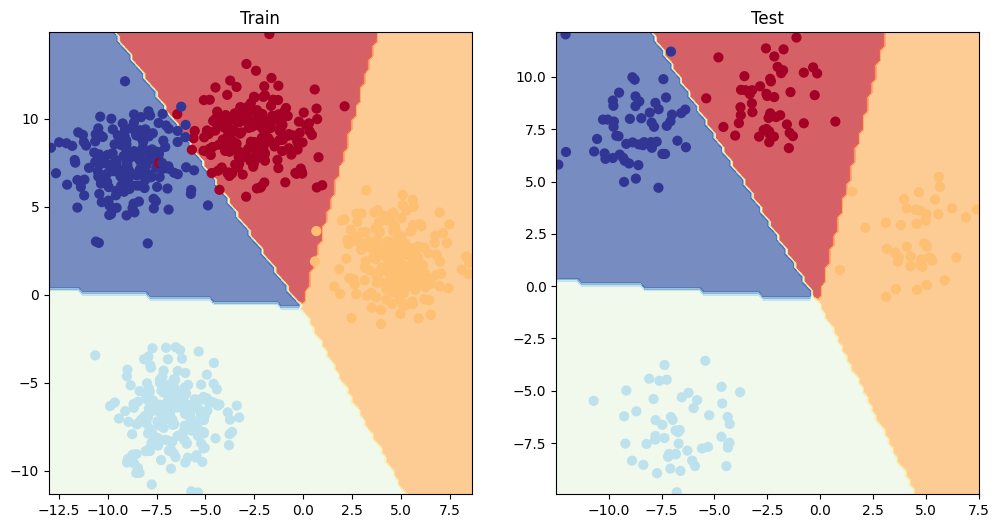

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(m4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(m4, X_blob_test, y_blob_test)

# More classification evaluation metrics

Accuracy - not suitable for imbalanced dataset
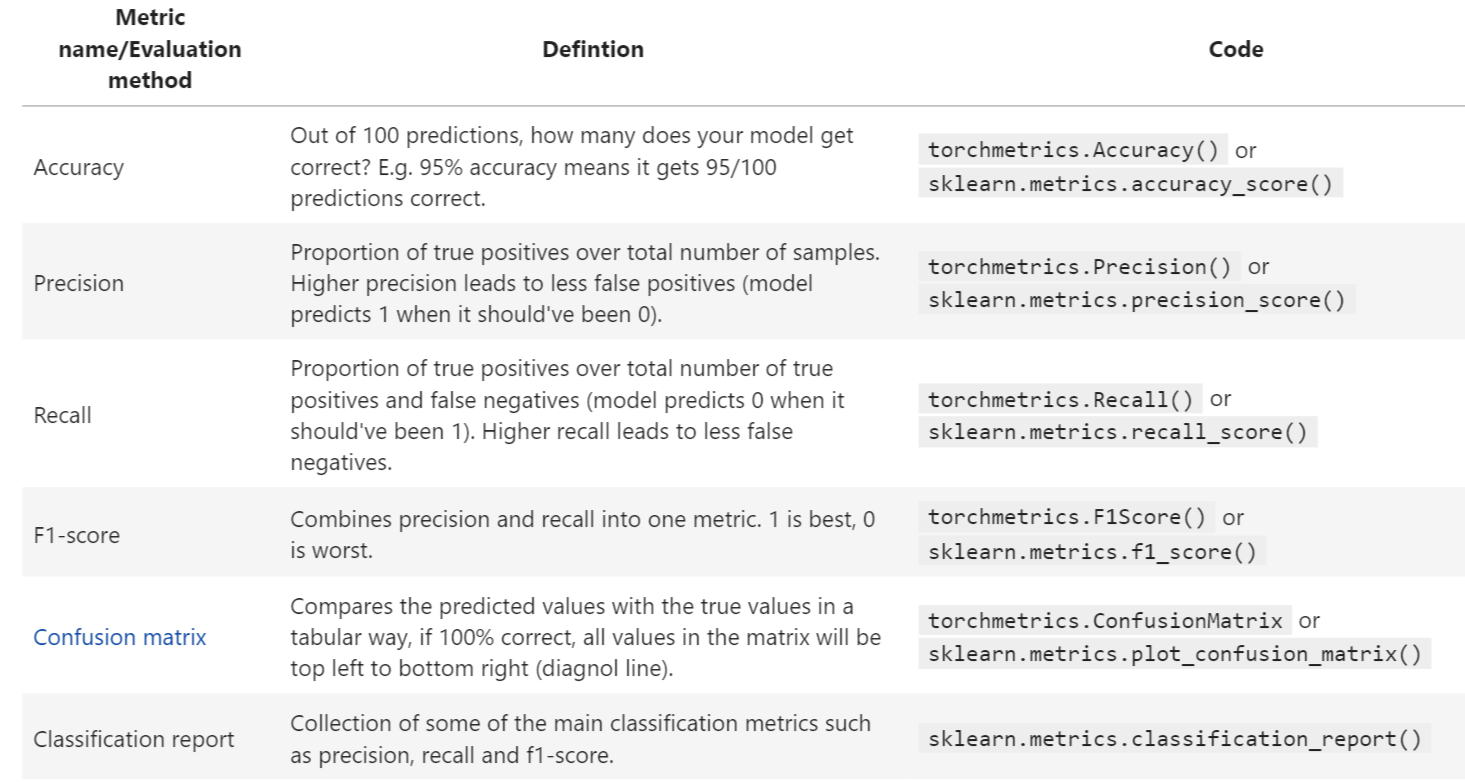

In [15]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy

# Setup metric
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 21.0 MB/s eta 0:00:00


tensor(0.9950)